# npzd

In [2]:
# import relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
# set parameter values

v_max = 1.1      # maximum photosynthetic rate in d-1
g_max = 0.8      # maximum ingestion rate in d-1  
K_N = 0.85       # half-saturation constant in umol N / L

m_P = 0.2        # mortality rate in d-1
m_Z = 0.1        # mortality rate in d-1
m_D = 0.6        # detritus remineralisation rate in %
kw = 0.05        # extinction coefficient due to water in m-1
kp = 0.03        # extinction coefficient due to phytoplankton in m-1
kappa = 0.1      # cross thermocline mixing in m d-1 
alpha = 0.15     # initial slope of P-I curve in XX
N0 = 15.0        # nutrients below the mixed layer depth in umol N / L
beta = 0.69      # zooplankton absorption efficiency 0.69 in %
K_Z = 0.6        # zooplankton half-saturation constant for intake in umol / L
K_NZ = 0.75      # zooplankton net production efficiency in %
m_Z2 = 0.34      # zooplankton mortality (closure) in (umol/L)-1 d-1
pP = 0.67        # grazing preference for phytoplankton in %
pD = 0.33        # grazing preference for detritus in %

In [4]:
# FOR SIMPLICITY ARTIFICAL FORCING:
ydays = np.arange(1,367,1)
mld = np.cos(ydays/365*np.pi*2) * 100 + 200
par = np.sin(ydays/365*np.pi) * 50 + 0
sst = np.sin(ydays/365*np.pi) * 10 + 10

ldiff = mld[365]-mld[364]

dt = 1.0                                 # 1.0 is the time interval (1 day)
dMdt = np.ediff1d(mld,to_end=ldiff)/dt   # calculating dM/dt, as in FASH93 pag.493, called also h, with h+ = max(h,0)

In [5]:
def mixing(t):
    k = (kappa + max(dMdt[t],0.))/mld[t]
    return k

def uptake(n):
    u = n/(n+K_N)
    return u

def grazingP(p,d):                                  # according to Anderson et al. 2015
    g = (g_max*pP*p*p/(K_Z**2 + pP*p*p + pD*d*d))   
    return g

def grazingD(p,d):                                  # according to Anderson et al. 2015
    g = (g_max*pD*d*d/(K_Z**2 + pP*p*p + pD*d*d))   
    return g

def temp(te): 
    E = np.exp(0.063*te)
    return E
 
def light(t,p):                                     # according to Anderson et al. 2015
    Iz = par[t]*np.exp(-(kw+kp*p)*mld[t])
    psi = (v_max/((kw+kp*p)*mld[t]))*np.log((alpha*par[t] + np.sqrt(v_max**2 + (alpha*par[t])**2))/(alpha*Iz + np.sqrt(v_max**2 + (alpha*Iz)**2)))
    return psi

In [6]:
def npzd(y, t):
    N, P, Z, D = y
    t = int(t) # small hack to allow indexing of new forcing (B.Post Jan 2020)

    dNdt = -(temp(sst[t])*uptake(N)*light(t,P))*P + beta*(1-K_NZ)*(grazingP(P,D) + grazingD(P,D))*Z + m_D*D + mixing(t)*(N0-N)
    
    dPdt = +(temp(sst[t])*uptake(N)*light(t,P))*P - m_P*P - grazingP(P,D)*Z - mixing(t)*P
    
    dZdt = beta*K_NZ*(grazingP(P,D) + grazingD(P,D))*Z - m_Z*Z - m_Z2*Z*Z - (dMdt[t]/mld[t])*Z

    dDdt = m_P*P + m_Z*Z + (1 - beta)*(grazingP(P,D) + grazingD(P,D))*Z - grazingD(P,D)*Z - m_D*D - mixing(t)*D
    
    dydt = [dNdt, dPdt, dZdt, dDdt]

    return dydt                                                           

In [7]:
# set vector of initial conditions, respectively for N(0), P(0), Z(0), and D(0)
y0 = [15.0, 0.01, 0.01, 0.01] 

# the time vector is (daily time step):
t = np.arange(0, 366, 1)


sol = odeint(npzd, y0, t, rtol=1e-12, atol=1e-12)  # sol contains the arrays of our solutions

In [9]:
%timeit odeint(npzd, y0, t, rtol=1e-12, atol=1e-12) 

2.49 s ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


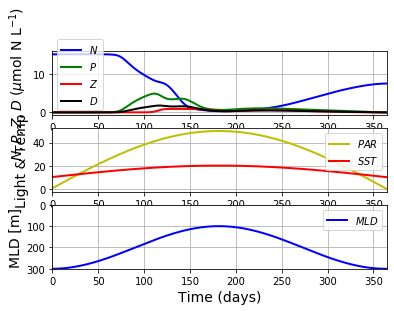

In [8]:
fig=plt.figure()

plt.subplot(311)

plt.plot(t, sol[:,0], 'b', lw=2, label='$N$')
plt.plot(t, sol[:,1], 'g', lw=2, label='$P$')
plt.plot(t, sol[:,2], 'r', lw=2, label='$Z$')
plt.plot(t, sol[:,3], 'k', lw=2, label='$D$')

plt.legend(loc='best')
plt.ylabel('$N,P,Z,D$ ($\mu$mol N L$^{-1}$)', fontsize=14)
plt.xlim([0,365])
#plt.ylim([0,12])

plt.grid()

# EDIT (B.Post, Jan 2020): ADDED SUBPLOTS TO SHOW FORCING
plt.subplot(312)
plt.plot(t, par, 'y', lw=2, label='$PAR$')
plt.plot(t, sst, 'r', lw=2, label='$SST$')
plt.xlim([0,365])

plt.legend(loc='best')
plt.ylabel('Light & Temp', fontsize=14)

plt.grid()

plt.subplot(313)
plt.plot(t, mld, 'b', lw=2, label='$MLD$')
plt.xlim([0,365])
plt.ylim([0,300])
plt.gca().invert_yaxis()


plt.legend(loc='best')
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('MLD [m]', fontsize=14)

plt.grid()
# END OF EDIT

plt.show()

# fig.savefig('npzd.pdf')